# Calculating accuracy and precision of gremlin contacts
accuracy   = (TP+TN)/(TP+TN+FP+FN)

precision/positive predictive value = TP/(TP+FP)

where: 
* TP: gremlin contact is present, native contact is present
* TN: gremlin contact is absent, native contact is absent
* FP: gremlin contact is present, native contact is absent
* FN: gremlin contact is absent, native contact is present

MDTRaj is used to calculate native contacts, then contacts generated by Gremlin can be analyzed for accuracy and precision.

In [50]:
import numpy as np 
import mdtraj
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
# load pdb of interest
pdb = '1UBQ.pdb'
# load uniprot and jackhammer contact data
uniprot = np.loadtxt('uniprot.gremlin',usecols=[0,1],skiprows=1)
jackhmmer = np.loadtxt('jackhmmer.gremlin',usecols=[0,1],skiprows=1)

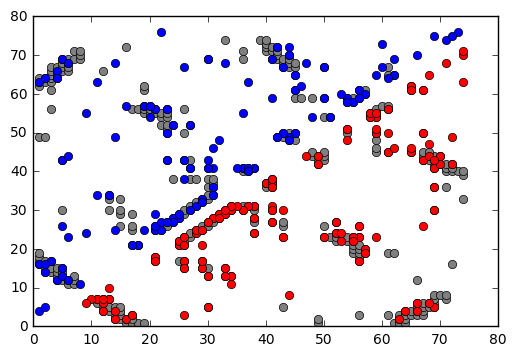

In [52]:
# calculate native contacts w/ mdtraj and load contacts from gremlin
# plot contact maps for CB-CB native contacts < 8.0 Angstroms
# and gremlin output from uniprot and metagenome searches
ref = mdtraj.load_pdb(pdb)
# get the indices of all of the heavy atoms
cbeta = ref.topology.select('name CB')
# get the pairs of heavy atoms which are farther than 3
# residues apart
cbeta_pairs = np.array(
    [(i,j) for (i,j) in combinations(cbeta, 2)
     if abs(ref.topology.atom(i).residue.index - \
            ref.topology.atom(j).residue.index) >= 3])
    
# compute the distances between these pairs in the native state
cbeta_pairs_distances = mdtraj.compute_distances(ref[0], cbeta_pairs)[0]
# and get the pairs if the distance is less than NATIVE_CUTOFF
contact_pairs = cbeta_pairs[cbeta_pairs_distances < 0.8]
# get residue numbers for contact_pairs
x1 = []
y1 = []
for i in range(len(contact_pairs)):
    res1 = ref.topology.atom(contact_pairs[i][0]).residue.index+1
    res2 = ref.topology.atom(contact_pairs[i][1]).residue.index+1
    x1.append(res1)
    y1.append(res2)

# make native contacts into array instead of list
nat_resi = np.asarray(x1)
nat_resj = np.asarray(y1)
nativeCB_contacts = np.column_stack((nat_resi, nat_resj))

seqlen = len(ref.topology.select('name CA'))

# make array of all possible CB contacts 3 or more residues apart
nativeCB_allpossible_contacts = np.array(
    [(i,j) for (i,j) in combinations(range(seqlen), 2)
    if abs(i - j) >= 3])

len(nativeCB_allpossible_contacts)

# plot contact map
x2 = uniprot[:,0]
y2 = uniprot[:,1]
x3 = jackhmmer[:,0]
y3 = jackhmmer[:,1]
plt.plot(x1,y1, 'gray', marker='o', linestyle='none')
plt.plot(y1,x1, 'gray', marker='o', linestyle='none')
plt.plot(x2,y2,'bo')
plt.plot(y3,x3,'ro')

In [53]:
# function for calculating positive predictive value (ppv)
def ppv(gremlin_dat):
    # calculate TP and FP
    tp = []
    fp = []
    for elem in gremlin_dat:
        match = np.where((nativeCB_contacts == (elem)).all(axis=1))
        #print(match)
        if match[0]:
            tp.append(match)
        if not match[0]:
            fp.append(match)
    TP = float(len(tp))
    FP = float(len(fp))
    ppv = TP/(TP + FP)
    return(ppv)

In [54]:
uniprot_ppv = ppv(uniprot)
jack_ppv = ppv(jackhmmer)
print(uniprot_ppv,jack_ppv)

(0.5964912280701754, 0.7631578947368421)


In [55]:
# function for calculating accuracy (acc)
def acc(gremlin_dat):
    nn = [] # native negative
    gn = [] # gremlin negative
    tn = []
    fn = []

    for elem in nativeCB_allpossible_contacts:
        gnmatch = np.where((gremlin_dat == (elem)).all(axis=1))
        nnmatch = np.where((nativeCB_contacts == (elem)).all(axis=1))
        if not gnmatch[0]:
            gn.append(elem)
        if not nnmatch[0]:
            nn.append(elem)

    nnarr = np.array(nn)
    gnarr = np.array(gn)

    for elem in gn:
        tnmatch = np.where((nn == (elem)).all(axis=1))
        if tnmatch[0]:
            tn.append(elem)
        if not tnmatch[0]:
            fn.append(elem)

    NN = float(len(nn))
    GN = float(len(gn))
    TN = float(len(tn))
    FN = float(len(fn))
    acc = (TP+TN)/(TP+TN+FP+FN)
    return(acc)

In [56]:
uniprot_acc = acc(uniprot)
jack_acc = acc(jackhmmer)
print(uniprot_acc,jack_acc)

(0.9382396449704142, 0.9452257586972613)
